# Intro
Name:  

    ORACLES_MERRA2_aerosol_cloud_contact

Purpose:  

    Prepare some first try analysis of the MERRA2 reanalysis with comparisons to ORACLES campaign for studying when/if aerosol   
    contact clouds
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - Sp_parameters.py : for Sp class definition, and for defining the functions used to build parameters
    - load_utils.py : for loading modis and other files
    - matplotlib
    - mpltools
    - numpy
    - scipy : for saving and reading
    - datetime
    - mpl_toolkits
    - gdal (from osgeo)
    - plotting_utils (user defined plotting routines)
    - map_utils, dependent on geopy
  
Needed Files:

  - MERRA2: AOD files
  - MERRA2: Cloud files
  - 4STAR AOD from ORACLES 2016
  
Modification History:
 
     Written: by Samuel LeBlanc, Santa Cruz, CA, 2018-08-08

# Load the python modules and set paths

In [1]:
import numpy as np
import scipy.io as sio
import os
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
import load_utils as lu
from Sp_parameters import smooth

import hdf5storage as hs
from mpltools import color
from path_utils import getpath
from write_utils import nearest_neighbor
from tqdm import tqdm_notebook as tqdm

In [4]:
import scipy.stats as st
import Sun_utils as su
from mpl_toolkits.basemap import Basemap

In [5]:
fp = getpath('ORACLES')
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'

# Load the various files

In [6]:
days = ['']

In [7]:
day = '20160914'

## Load 4STAR gap distance calculations for ORACLES 2016

In [9]:
gap = hs.loadmat(fp+'ORACLES_2016_gap_distance.mat')

In [10]:
gap['ldelta_alt'].shape

(138,)

In [287]:
gap['days'] = [i[0] for i in gap['ldelta_lat_days']]

In [303]:
{i:gap['days'].count(i) for i in gap['days']}

{20160827.0: 4,
 20160831.0: 12,
 20160902.0: 13,
 20160904.0: 5,
 20160906.0: 14,
 20160908.0: 12,
 20160910.0: 12,
 20160912.0: 9,
 20160914.0: 14,
 20160918.0: 5,
 20160920.0: 11,
 20160924.0: 11,
 20160925.0: 12,
 20160927.0: 4}

In [304]:
days = ['{:8.0f}'.format(i) for i in np.unique(gap['days'])]
days

['20160827',
 '20160831',
 '20160902',
 '20160904',
 '20160906',
 '20160908',
 '20160910',
 '20160912',
 '20160914',
 '20160918',
 '20160920',
 '20160924',
 '20160925',
 '20160927']

## Load the MERRA2 2d aerosol files

In [6]:
fpma = fp+'data_other/MERRA2/'

In [248]:
merra2_gas2d = lu.load_netcdf(fpma+'MERRA2_400.inst3_2d_gas_Nx.{}.nc4.nc'.format(day),values=(('AODANA',0),('AODINC',1),('lat',2),('lon',3),('time',4)))

Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/MERRA2_400.inst3_2d_gas_Nx.20160914.nc4.nc
Outputting the Data subdatasets:
0: AODANA
1: AODINC
2: lat
3: lon
4: time
['AODANA', 'lat', 'AODINC', 'lon', 'time']


In [8]:
merra2_gas2d

({'AODANA': array([[[ 0.04327324,  0.04266344,  0.04226571, ...,  0.12277858,
            0.13107193,  0.13631585],
          [ 0.04045776,  0.04069982,  0.03947369, ...,  0.08532289,
            0.08498371,  0.084736  ],
          [ 0.03859564,  0.03874294,  0.03750155, ...,  0.06870438,
            0.07080717,  0.07035366],
          ..., 
          [ 0.17251983,  0.16159394,  0.15045986, ...,  0.23371834,
            0.25477049,  0.28373885],
          [ 0.14344274,  0.14984097,  0.15117018, ...,  0.28830746,
            0.30901119,  0.34243894],
          [ 0.19289151,  0.18171108,  0.17316884, ...,  0.31861746,
            0.3496426 ,  0.38359028]],
  
         [[ 0.0431271 ,  0.04141783,  0.04076279, ...,  0.11242079,
            0.1108918 ,  0.10977064],
          [ 0.04030513,  0.04077312,  0.04003961, ...,  0.11970394,
            0.11081574,  0.1043994 ],
          [ 0.03888019,  0.03907305,  0.0381741 , ...,  0.1018253 ,
            0.09269387,  0.0843364 ],
          ..., 


## Load the MERRA2 clouds

In [348]:
mclds = []
for day in days:
    print day
    mcld,mcld_info = lu.load_netcdf(fpma+'clouds_model/MERRA2_400.tavg3_3d_cld_Nv.{}.SUB.nc'.format(day),everything=True)
    mclds.append(mcld)

20160827
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/clouds_model/MERRA2_400.tavg3_3d_cld_Nv.20160827.SUB.nc
Outputting the Data subdatasets:
0: CLOUD
1: INCLOUDQL
2: QL
3: TAUCLW
4: lat
5: lev
6: lon
7: time
['lon', 'lat', 'INCLOUDQL', 'lev', 'time', 'TAUCLW', 'QL', 'CLOUD']
20160831
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/clouds_model/MERRA2_400.tavg3_3d_cld_Nv.20160831.SUB.nc
Outputting the Data subdatasets:
0: CLOUD
1: DELP
2: PS
3: QL
4: TAUCLW
5: lat
6: lev
7: lon
8: time
['PS', 'lat', 'lon', 'DELP', 'lev', 'time', 'TAUCLW', 'QL', 'CLOUD']
20160902
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/clouds_model/MERRA2_400.tavg3_3d_cld_Nv.20160902.SUB.nc
Outputting the Data subdatasets:
0: CLOUD
1: DELP
2: PS
3: QL
4: TAUCLW
5: lat
6: lev
7: lon
8: time
['PS', 'lat', 'lon', 'DELP', 'lev', 'time', 'TAUCLW', 'QL', 'CLOUD']
20160904
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/clou

In [10]:
mcld_info

{'CLOUD': <type 'netCDF4._netCDF4.Variable'>
 float32 CLOUD(time, lev, lat, lon)
     standard_name: cloud_fraction_for_radiation
     long_name: cloud_fraction_for_radiation
     units: 1
     _FillValue: 1e+15
     missing_value: 1e+15
     fmissing_value: 1e+15
     vmax: 1e+15
     vmin: -1e+15
 unlimited dimensions: time
 current shape = (8, 72, 101, 113)
 filling on, 'DELP': <type 'netCDF4._netCDF4.Variable'>
 float32 DELP(time, lev, lat, lon)
     standard_name: pressure_thickness
     long_name: pressure_thickness
     units: Pa
     _FillValue: 1e+15
     missing_value: 1e+15
     fmissing_value: 1e+15
     vmax: 1e+15
     vmin: -1e+15
 unlimited dimensions: time
 current shape = (8, 72, 101, 113)
 filling on, 'PS': <type 'netCDF4._netCDF4.Variable'>
 float32 PS(time, lat, lon)
     standard_name: surface_pressure
     long_name: surface_pressure
     units: Pa
     _FillValue: 1e+15
     missing_value: 1e+15
     fmissing_value: 1e+15
     vmax: 1e+15
     vmin: -1e+15
 unli

In [11]:
mcld['lev'].shape

(72,)

In [217]:
mcld['DELP'].shape

(8, 72, 101, 113)

In [13]:
mcld['DELP'][1,:,50,50]

array([  1.00000012e+00,   1.27000034e+00,   1.48850060e+00,
         1.84149969e+00,   2.33449960e+00,   3.03580022e+00,
         3.97920203e+00,   5.18540144e+00,   6.71770287e+00,
         8.65150356e+00,   1.10765038e+01,   1.40973015e+01,
         1.78355083e+01,   2.24306049e+01,   2.81069965e+01,
         3.50280113e+01,   4.34180260e+01,   5.35240326e+01,
         6.56220322e+01,   8.00140381e+01,   9.70229797e+01,
         1.17000000e+02,   1.40304123e+02,   1.67310043e+02,
         1.98395996e+02,   2.36649948e+02,   2.81370117e+02,
         3.33450165e+02,   3.93880005e+02,   4.63740143e+02,
         5.44220398e+02,   6.36540100e+02,   7.46849854e+02,
         8.74400146e+02,   1.02155060e+03,   1.19089050e+03,
         1.38534033e+03,   1.62972998e+03,   1.91740198e+03,
         2.25560034e+03,   2.65370239e+03,   3.13585254e+03,
         3.71364990e+03,   4.39080420e+03,   5.03956787e+03,
         3.83349902e+03,   3.83664258e+03,   3.84058569e+03,
         3.84354150e+03,

### Load the MERRA2 cloud pressure levels

In [250]:
mcldp,mcldp_info = lu.load_netcdf(fpma+'clouds_press/MERRA2_400.tavg3_3d_cld_Np.{}.SUB.nc'.format(day),everything=True)

Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/clouds_press/MERRA2_400.tavg3_3d_cld_Np.20160914.SUB.nc
Outputting the Data subdatasets:
0: CFCU
1: CLOUD
2: DTRAIN
3: INCLOUDQI
4: INCLOUDQL
5: QI
6: QL
7: RH
8: TAUCLI
9: TAUCLW
10: lat
11: lev
12: lon
13: time
['DTRAIN', 'TAUCLI', 'time', 'lon', 'lat', 'TAUCLW', 'INCLOUDQL', 'lev', 'INCLOUDQI', 'QI', 'CFCU', 'RH', 'QL', 'CLOUD']


In [15]:
mcldp['lev'].shape

(42,)

## Load the MERRA2 aerosol

In [349]:
maeros = []
for day in days:
    print day
    maero,maero_info = lu.load_netcdf(fpma+'aero_model/MERRA2_400.inst3_3d_aer_Nv.{}.nc4'.format(day),everything=True)
    maeros.append(maero)

20160827
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/aero_model/MERRA2_400.inst3_3d_aer_Nv.20160827.nc4
Outputting the Data subdatasets:
0: AIRDENS
1: BCPHILIC
2: BCPHOBIC
3: DELP
4: DMS
5: DU001
6: DU002
7: DU003
8: DU004
9: DU005
10: LWI
11: MSA
12: OCPHILIC
13: OCPHOBIC
14: PS
15: RH
16: SO2
17: SO4
18: SS001
19: SS002
20: SS003
21: SS004
22: SS005
23: lat
24: lev
25: lon
26: time
['DMS', 'MSA', 'PS', 'lon', 'DU004', 'DU005', 'DU002', 'DU003', 'DU001', 'RH', 'BCPHILIC', 'time', 'OCPHILIC', 'SO2', 'SO4', 'lev', 'lat', 'DELP', 'OCPHOBIC', 'LWI', 'BCPHOBIC', 'AIRDENS', 'SS003', 'SS002', 'SS001', 'SS005', 'SS004']
20160831
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/aero_model/MERRA2_400.inst3_3d_aer_Nv.20160831.nc4
Outputting the Data subdatasets:
0: AIRDENS
1: BCPHILIC
2: BCPHOBIC
3: DELP
4: DMS
5: DU001
6: DU002
7: DU003
8: DU004
9: DU005
10: LWI
11: MSA
12: OCPHILIC
13: OCPHOBIC
14: PS
15: RH
16: SO2
17: SO4
18: SS001
19: SS002
2

['DMS', 'MSA', 'PS', 'lon', 'DU004', 'DU005', 'DU002', 'DU003', 'DU001', 'RH', 'BCPHILIC', 'time', 'OCPHILIC', 'SO2', 'SO4', 'lev', 'lat', 'DELP', 'OCPHOBIC', 'LWI', 'BCPHOBIC', 'AIRDENS', 'SS003', 'SS002', 'SS001', 'SS005', 'SS004']
20160918
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/aero_model/MERRA2_400.inst3_3d_aer_Nv.20160918.nc4
Outputting the Data subdatasets:
0: AIRDENS
1: BCPHILIC
2: BCPHOBIC
3: DELP
4: DMS
5: DU001
6: DU002
7: DU003
8: DU004
9: DU005
10: LWI
11: MSA
12: OCPHILIC
13: OCPHOBIC
14: PS
15: RH
16: SO2
17: SO4
18: SS001
19: SS002
20: SS003
21: SS004
22: SS005
23: lat
24: lev
25: lon
26: time
['DMS', 'MSA', 'PS', 'lon', 'DU004', 'DU005', 'DU002', 'DU003', 'DU001', 'RH', 'BCPHILIC', 'time', 'OCPHILIC', 'SO2', 'SO4', 'lev', 'lat', 'DELP', 'OCPHOBIC', 'LWI', 'BCPHOBIC', 'AIRDENS', 'SS003', 'SS002', 'SS001', 'SS005', 'SS004']
20160920
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/aero_model/MERRA2_400.inst3_3d_aer_Nv.

In [322]:
maero_info

{'AIRDENS': <type 'netCDF4._netCDF4.Variable'>
 float32 AIRDENS(time, lev, lat, lon)
     standard_name: air_density
     long_name: air_density
     units: kg m-3
     _FillValue: 1e+15
     missing_value: 1e+15
     fmissing_value: 1e+15
     vmax: 1e+15
     vmin: -1e+15
 unlimited dimensions: time
 current shape = (5, 72, 101, 113)
 filling on, 'BCPHILIC': <type 'netCDF4._netCDF4.Variable'>
 float32 BCPHILIC(time, lev, lat, lon)
     standard_name: Hydrophilic Black Carbon
     long_name: Hydrophilic Black Carbon
     units: kg kg-1
     _FillValue: 1e+15
     missing_value: 1e+15
     fmissing_value: 1e+15
     vmax: 1e+15
     vmin: -1e+15
 unlimited dimensions: time
 current shape = (5, 72, 101, 113)
 filling on, 'BCPHOBIC': <type 'netCDF4._netCDF4.Variable'>
 float32 BCPHOBIC(time, lev, lat, lon)
     standard_name: Hydrophobic Black Carbon
     long_name: Hydrophobic Black Carbon
     units: kg kg-1
     _FillValue: 1e+15
     missing_value: 1e+15
     fmissing_value: 1e+15
  

In [350]:
ll=[]
for k in maero_info.keys():
    print k,maero_info[k].long_name, maero_info[k].units
    if maero_info[k].units=='kg kg-1': ll.append(k)

DMS Dimethylsulphide kg kg-1
MSA Methanesulphonic acid kg kg-1
PS surface_pressure Pa
lon longitude degrees_east
DU004 Dust Mixing Ratio (bin 004) kg kg-1
DU005 Dust Mixing Ratio (bin 005) kg kg-1
DU002 Dust Mixing Ratio (bin 002) kg kg-1
DU003 Dust Mixing Ratio (bin 003) kg kg-1
DU001 Dust Mixing Ratio (bin 001) kg kg-1
RH relative_humidity_after_moist 1
BCPHILIC Hydrophilic Black Carbon kg kg-1
time time minutes since 2016-09-27 00:00:00
OCPHILIC Hydrophilic Organic Carbon (Particulate Matter) kg kg-1
SO2 Sulphur dioxide kg kg-1
SO4 Sulphate aerosol kg kg-1
lev vertical level layer
lat latitude degrees_north
DELP pressure_thickness Pa
OCPHOBIC Hydrophobic Organic Carbon (Particulate Matter) kg kg-1
LWI land(1)_water(0)_ice(2)_flag 1
BCPHOBIC Hydrophobic Black Carbon kg kg-1
AIRDENS air_density kg m-3
SS003 Sea Salt Mixing Ratio (bin 003) kg kg-1
SS002 Sea Salt Mixing Ratio (bin 002) kg kg-1
SS001 Sea Salt Mixing Ratio (bin 001) kg kg-1
SS005 Sea Salt Mixing Ratio (bin 005) kg kg-1
SS

In [351]:
ll

['DMS',
 'MSA',
 'DU004',
 'DU005',
 'DU002',
 'DU003',
 'DU001',
 'BCPHILIC',
 'OCPHILIC',
 'SO2',
 'SO4',
 'OCPHOBIC',
 'BCPHOBIC',
 'SS003',
 'SS002',
 'SS001',
 'SS005',
 'SS004']

In [312]:
maero['tot_aero'] = 0
for l in ll:
    maero['tot_aero'] = maero['tot_aero']+maero[l]

In [352]:
for i,day in enumerate(days):
    maeros[i]['tot_aero'] = 0
    for l in ll:
        maeros[i]['tot_aero'] = maeros[i]['tot_aero']+maeros[i][l]
    maeros[i]['scat'] = maeros[i]['tot_aero']*maeros[i]['AIRDENS']*1000.0*2.18*1000.0*1000.0
    

In [261]:
maero['tot_aero'].shape

(5, 72, 101, 113)

In [262]:
maero['scat'] = maero['tot_aero']*maero['AIRDENS']*1000.0*2.18*1000.0*1000.0

In [257]:
maero['AIRDENS'].shape

(5, 72, 101, 113)

## Load the MERRA2 atmosphere files for altitudes

In [353]:
matms = []
for day in days:
    print day
    matm,matm_info = lu.load_netcdf(fpma+'atm_model/MERRA2_400.inst3_3d_asm_Nv.{}.SUB.nc'.format(day),everything=True)
    matms.append(matm)

20160827
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/atm_model/MERRA2_400.inst3_3d_asm_Nv.20160827.SUB.nc
Outputting the Data subdatasets:
0: CLOUD
1: DELP
2: EPV
3: H
4: O3
5: OMEGA
6: PHIS
7: PL
8: PS
9: QI
10: QL
11: QV
12: RH
13: SLP
14: T
15: U
16: V
17: lat
18: lev
19: lon
20: time
['PS', 'lat', 'time', 'QV', 'EPV', 'O3', 'V', 'SLP', 'T', 'lon', 'DELP', 'PHIS', 'PL', 'lev', 'H', 'QI', 'U', 'OMEGA', 'QL', 'CLOUD', 'RH']
20160831
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/atm_model/MERRA2_400.inst3_3d_asm_Nv.20160831.SUB.nc
Outputting the Data subdatasets:
0: DELP
1: H
2: PHIS
3: PL
4: PS
5: lat
6: lev
7: lon
8: time
['PS', 'H', 'lon', 'DELP', 'PHIS', 'lev', 'time', 'lat', 'PL']
20160902
Reading file: /mnt/c/Users/sleblanc/Research/ORACLES/data_other/MERRA2/atm_model/MERRA2_400.inst3_3d_asm_Nv.20160902.SUB.nc
Outputting the Data subdatasets:
0: DELP
1: H
2: PHIS
3: PL
4: PS
5: lat
6: lev
7: lon
8: time
['PS', 'H', 'lon', 'DELP'

In [264]:
matm_info['H']

<type 'netCDF4._netCDF4.Variable'>
float32 H(time, lev, lat, lon)
    standard_name: mid_layer_heights
    long_name: mid_layer_heights
    units: m
    _FillValue: 1e+15
    missing_value: 1e+15
    fmissing_value: 1e+15
    vmax: 1e+15
    vmin: -1e+15
unlimited dimensions: time
current shape = (8, 72, 101, 113)
filling on

In [265]:
matm['H'].shape

(8, 72, 101, 113)

In [26]:
matm['H'][5,:,50,50]/1000.0

array([  7.60774536e+01,   7.25743256e+01,   6.99691315e+01,
         6.78039246e+01,   6.57937164e+01,   6.38464165e+01,
         6.19179077e+01,   5.99901009e+01,   5.80669136e+01,
         5.61456375e+01,   5.42180138e+01,   5.22777023e+01,
         5.03319206e+01,   4.84070778e+01,   4.65187569e+01,
         4.46661797e+01,   4.28619537e+01,   4.11310844e+01,
         3.94847984e+01,   3.79023285e+01,   3.63623085e+01,
         3.48679657e+01,   3.34270096e+01,   3.20463219e+01,
         3.07301826e+01,   2.94663734e+01,   2.82391510e+01,
         2.70385075e+01,   2.58634453e+01,   2.47173309e+01,
         2.36043625e+01,   2.25251141e+01,   2.14717884e+01,
         2.04377022e+01,   1.94276848e+01,   1.84499416e+01,
         1.74994354e+01,   1.65559578e+01,   1.56030722e+01,
         1.46420002e+01,   1.36586466e+01,   1.26382580e+01,
         1.15784893e+01,   1.04720316e+01,   9.33305264e+00,
         8.36912727e+00,   7.61780357e+00,   6.92217779e+00,
         6.27418566e+00,

# Make a few plots

In [27]:
maero['lon'].shape

(113,)

In [28]:
maero['lat'].shape

(101,)

In [29]:
maero['time'].shape

(5,)

In [30]:
maero['lev'].shape

(72,)

In [31]:
maero['DMS'].shape

(5, 72, 101, 113)

In [32]:
maero['time']

array([  360.,   540.,   720.,   900.,  1080.])

In [33]:
maero['lev']

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.])

<IPython.core.display.Javascript object>


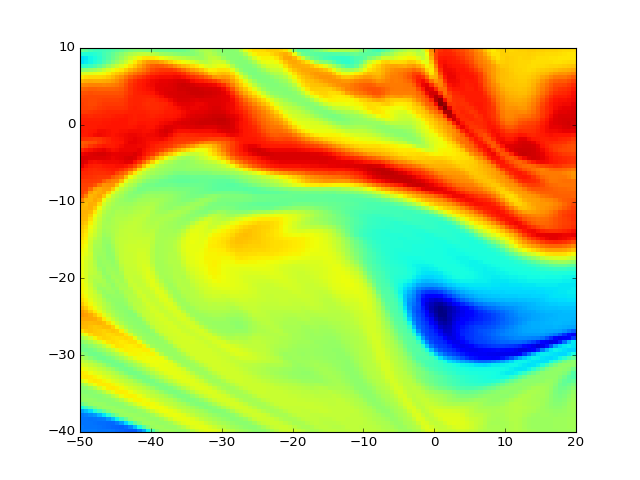

In [227]:
plt.figure()
plt.pcolor(maero['lon'],maero['lat'],maero['tot_aero'][2,10,:,:])

In [37]:
maero['time']/60.0

array([  6.,   9.,  12.,  15.,  18.])

In [43]:
maero['lon'][60],maero['lat'][70]

(-12.5, -5.0)

In [49]:
mcld_info['QL']

<type 'netCDF4._netCDF4.Variable'>
float32 QL(time, lev, lat, lon)
    standard_name: mass_fraction_of_cloud_liquid_water
    long_name: mass_fraction_of_cloud_liquid_water
    units: kg kg-1
    _FillValue: 1e+15
    missing_value: 1e+15
    fmissing_value: 1e+15
    vmax: 1e+15
    vmin: -1e+15
unlimited dimensions: time
current shape = (8, 72, 101, 113)
filling on

In [63]:
matm_info['H']

<type 'netCDF4._netCDF4.Variable'>
float32 H(time, lev, lat, lon)
    standard_name: mid_layer_heights
    long_name: mid_layer_heights
    units: m
    _FillValue: 1e+15
    missing_value: 1e+15
    fmissing_value: 1e+15
    vmax: 1e+15
    vmin: -1e+15
unlimited dimensions: time
current shape = (8, 72, 101, 113)
filling on

In [84]:
mcld['cld_n'] = mcld['QL']*maero['AIRDENS']

ValueError: operands could not be broadcast together with shapes (8,72,101,113) (5,72,101,113) 

In [228]:
mcld['time']/60.0

array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.])

In [229]:
maero['time']/60.0

array([  6.,   9.,  12.,  15.,  18.])

In [230]:
matm['time']/60.0

array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.])

In [231]:
ii,ij = 60,70

In [232]:
iis = [40,50,60,70]
ijs = [60,70,80,90]

<IPython.core.display.Javascript object>


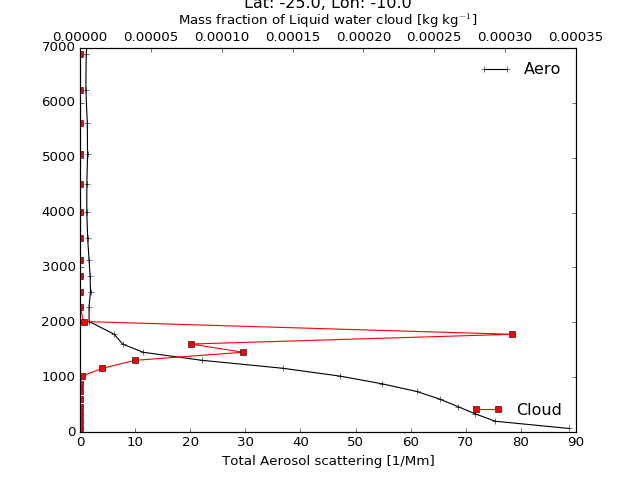

<IPython.core.display.Javascript object>


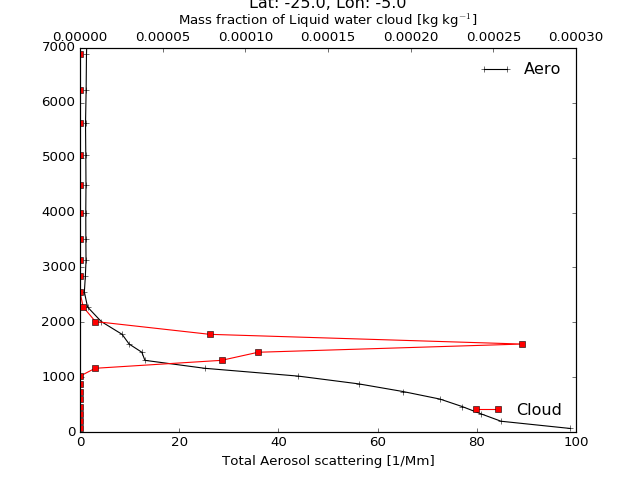

<IPython.core.display.Javascript object>


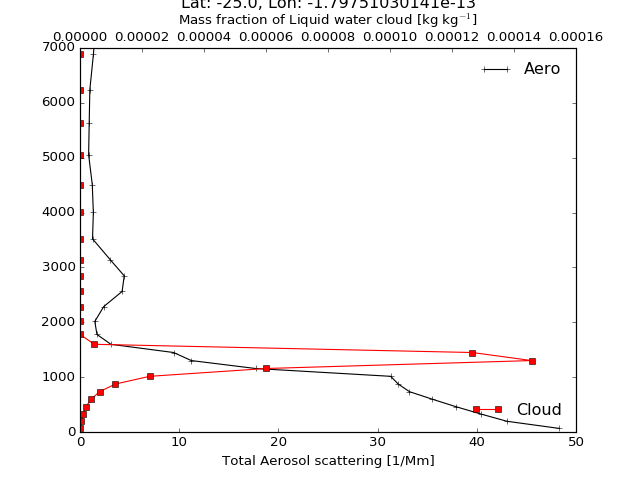

<IPython.core.display.Javascript object>


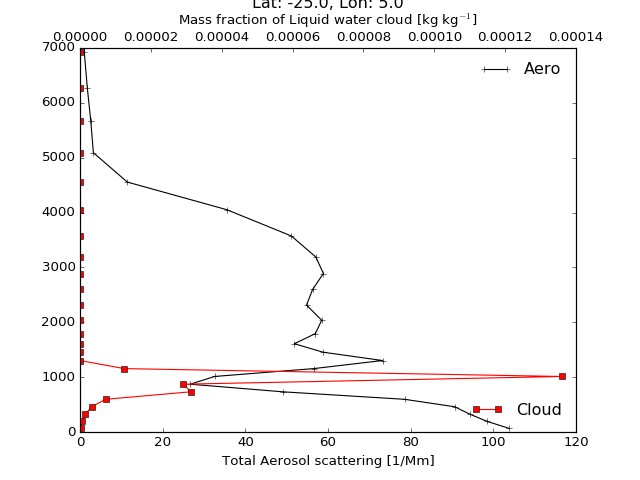

<IPython.core.display.Javascript object>


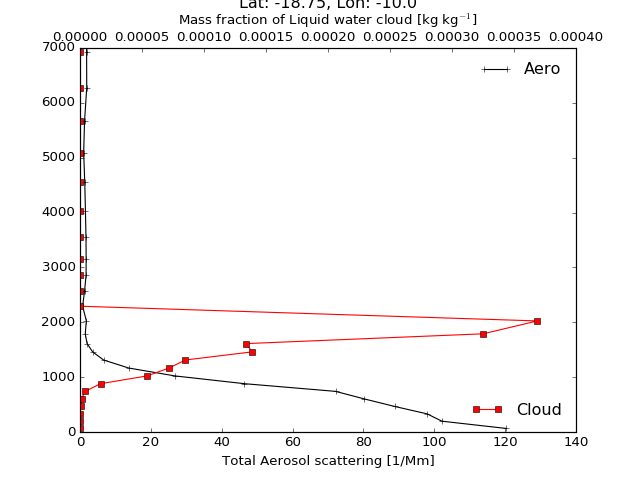

<IPython.core.display.Javascript object>


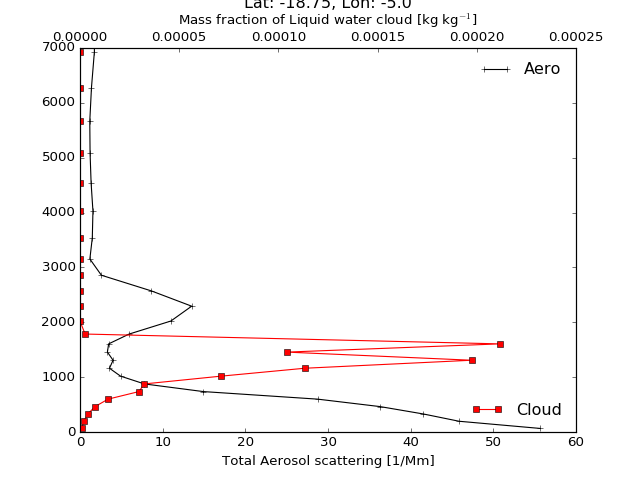

<IPython.core.display.Javascript object>


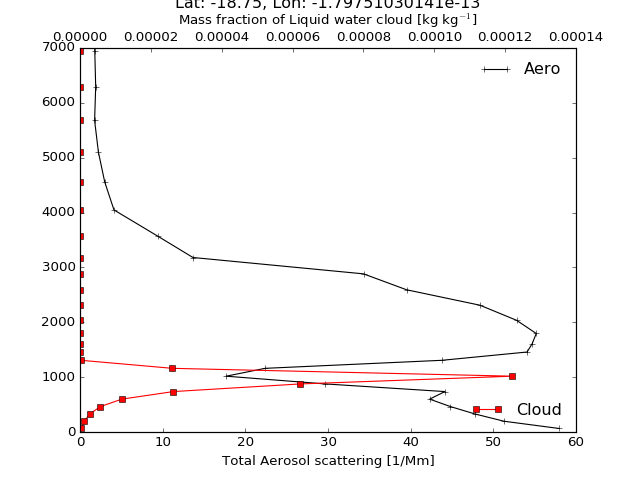

<IPython.core.display.Javascript object>


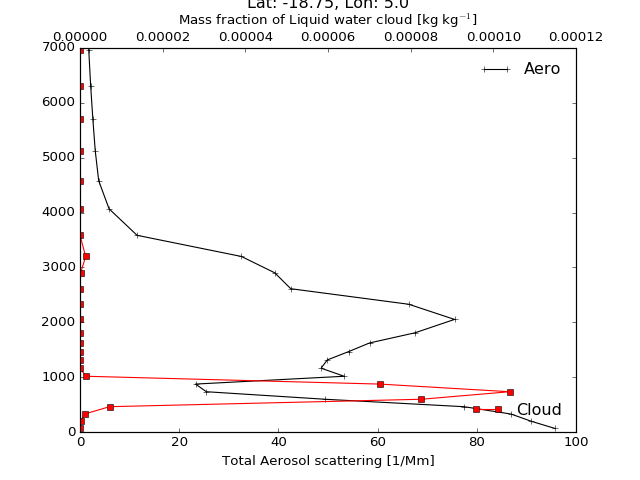

<IPython.core.display.Javascript object>


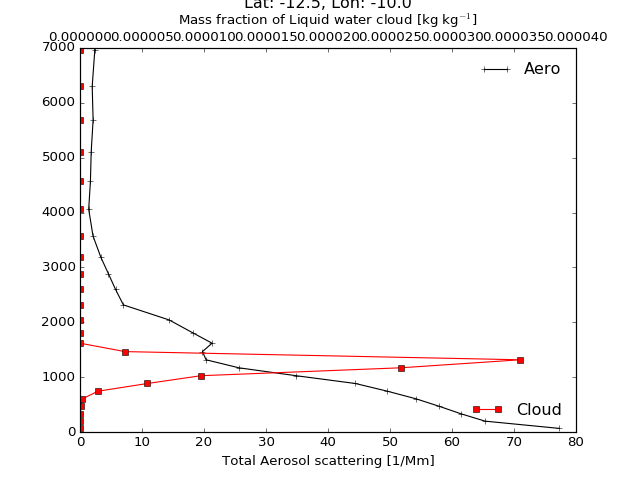

<IPython.core.display.Javascript object>


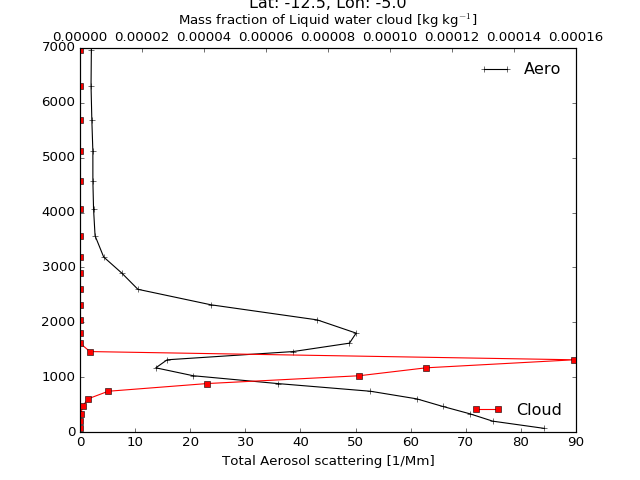

<IPython.core.display.Javascript object>


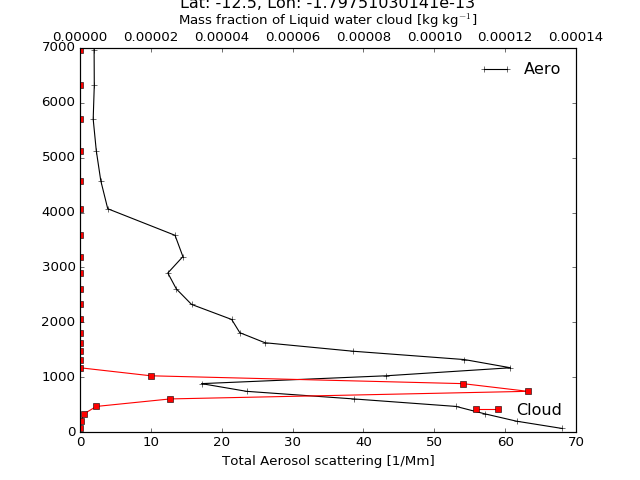

<IPython.core.display.Javascript object>


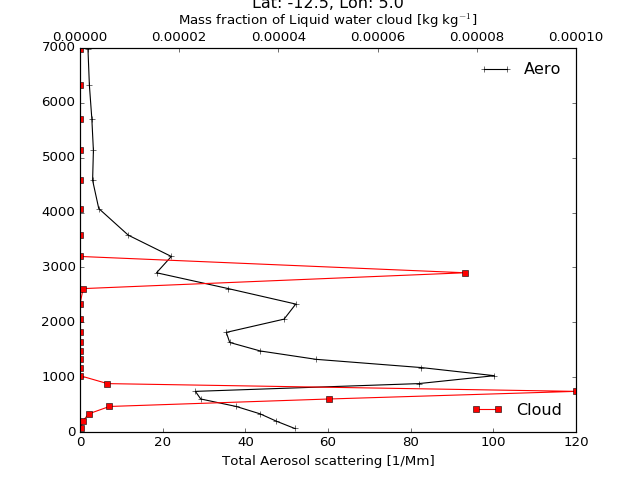

<IPython.core.display.Javascript object>


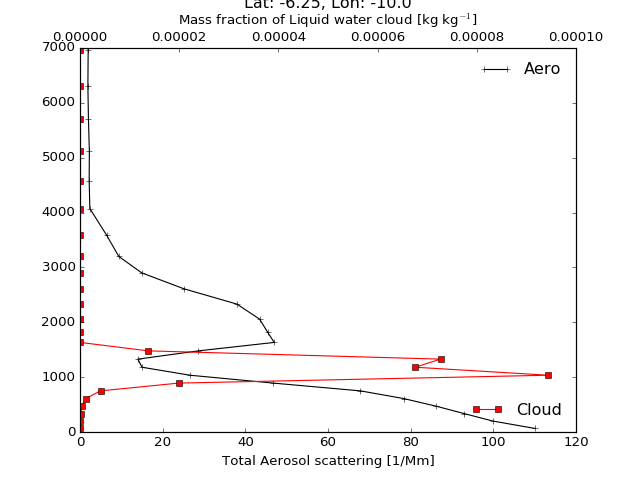

<IPython.core.display.Javascript object>


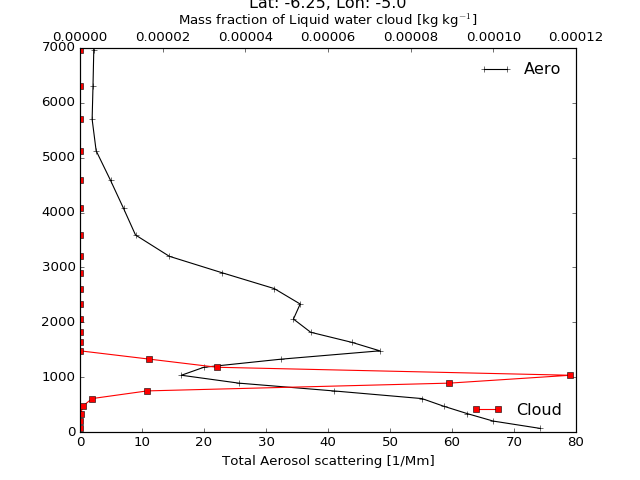

<IPython.core.display.Javascript object>


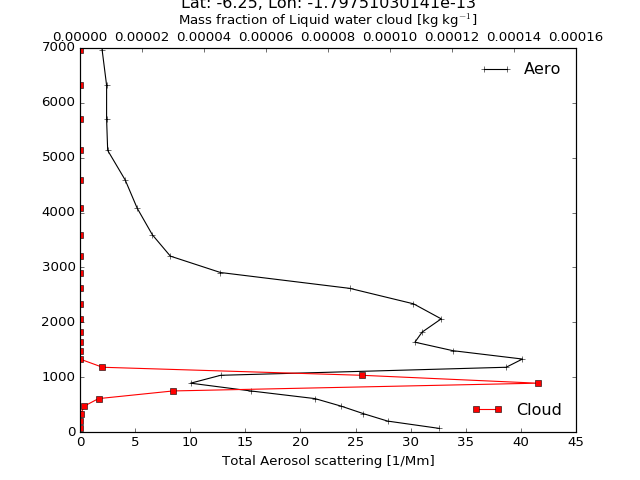

<IPython.core.display.Javascript object>


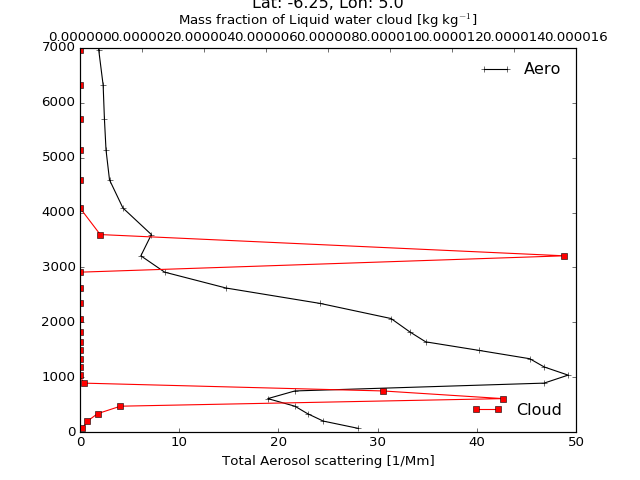

In [90]:
for ii in iis:
    for ij in ijs:
        plt.figure()
        plt.plot(maero['scat'][1,:,ii,ij],matm['H'][3,:,ii,ij],'k-+',label='Aero')
        plt.legend(frameon=False)

        #plt.xlabel('Total Aerosol Content Mass fraction [kg kg$^{{-1}}$]')
        plt.xlabel('Total Aerosol scattering [1/Mm]')
        ax2 = plt.gca().twiny()
        ax2.plot(mcld['QL'][3,:,ii,ij],matm['H'][3,:,ii,ij],'r-s',label='Cloud')
        ax2.set_ylabel('Altitude [m]')
        ax2.set_xlabel('Mass fraction of Liquid water cloud [kg kg$^{{-1}}$]')
        plt.ylim(0,7000)
        plt.legend(frameon=False,loc=4)
        plt.title('Lat: {}, Lon: {}\n\n'.format(maero['lon'][ii],maero['lat'][ij]))


# Now combine cloud and aerosol to find vertical distance between them

## Test with one case

In [266]:
maero['isaero'] = maero['scat']>50.0
mcld['iscld'] = mcld['QL']>0.00001

In [354]:
for i,day in enumerate(days):
    maeros[i]['isaero'] = maeros[i]['scat']>50.0
    mclds[i]['iscld'] = mclds[i]['QL']>0.00001

In [333]:
day

'20160827'

In [267]:
maero['isaero'].shape, mcld['iscld'].shape

((5, 72, 101, 113), (8, 72, 101, 113))

<IPython.core.display.Javascript object>


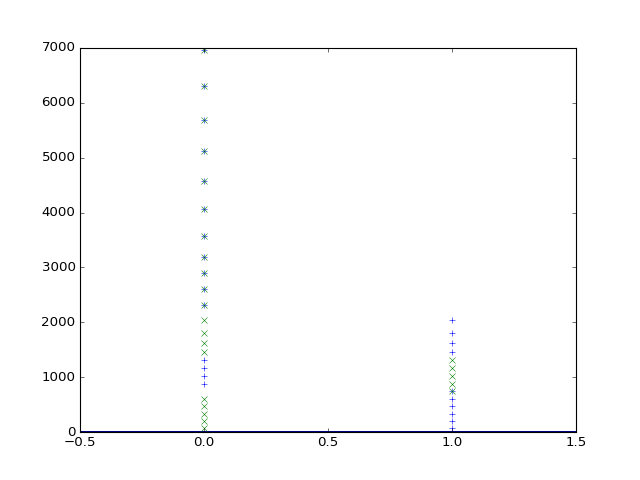

(0, 7000)

In [146]:
plt.figure()
plt.plot(maero['isaero'][1,:,60,72],matm['H'][3,:,60,72],'+')
plt.plot(mcld['iscld'][3,:,60,72],matm['H'][3,:,60,72],'x')
plt.xlim(-0.5,1.5)
plt.ylim(0,7000)

In [98]:
def start_stop(a, trigger_val, len_thresh=2):
    # "Enclose" mask with sentients to catch shifts later on
    mask = np.r_[False,np.equal(a, trigger_val),False]

    # Get the shifting indices
    idx = np.flatnonzero(mask[1:] != mask[:-1])

    # Get lengths
    lens = idx[1::2] - idx[::2]

    return idx.reshape(-1,2)[lens>len_thresh]-[0,1]

In [147]:
idx = start_stop(maero['isaero'][1,:,60,72],True,len_thresh=0)
idc = start_stop(mcld['iscld'][3,:,60,72],True,len_thresh=0)
idx,idc

(array([[58, 61],
        [66, 71]]), array([[62, 66]]))

In [148]:
iwithin = start_stop((maero['isaero'][1,:,60,72] & mcld['iscld'][3,:,60,72]),True,len_thresh=0)
iwithin

array([[66, 66]])

In [149]:
iabove,ibelow = [],[]
for ix in idx:
    for ic in idc:
        if ix[0]>=ic[1]: ibelow.append([ic[1],ix[0]])
        if ix[1]<=ic[0]: iabove.append([ix[1],ic[0]])
iabove,ibelow

([[61, 62]], [[66, 66]])

In [153]:
zwithin,zabove,zbelow = [],[],[]
for iw in iwithin: zwithin.append((matm['H'][3,iw[0],60,72]+matm['H'][3,iw[0]-1,60,72])/2.0\
                                  -(matm['H'][3,iw[1],60,72]+matm['H'][3,iw[1]+1,60,72])/2.0)
if not zwithin: zwithin.append(0.0)
for ia in iabove: zabove.append(matm['H'][3,ia[0],60,72]-matm['H'][3,ia[1],60,72])
if not zabove: zabove.append(0.0)
for ib in ibelow: zbelow.append(matm['H'][3,ib[0],60,72]-matm['H'][3,ib[1],60,72])
if not zbelow: zbelow.append(0.0)
zwithin,zabove,zbelow

([139.4503173828125], [150.47559], [0.0])

## Now redo but for entire region

In [360]:
zwi,zab,zbe = [],[],[]
for i,maeroi in enumerate(maeros):
    matmi = matms[i]
    mcldi = mclds[i]
    print days[i]
    pbar = tqdm(total=len(maeroi['time'])*len(maeroi['lat'])*len(maeroi['lon']))
    zw = np.zeros((len(maeroi['time']),len(maeroi['lat']),len(maeroi['lon']),20))*np.nan
    za =  np.zeros((len(maeroi['time']),len(maeroi['lat']),len(maeroi['lon']),20))*np.nan
    zb =  np.zeros((len(maeroi['time']),len(maeroi['lat']),len(maeroi['lon']),20))*np.nan
    for it in range(len(maeroi['time'])):
        ita = np.argmin(abs(maeroi['time'][it]-matmi['time']))
        itc = np.argmin(abs(maeroi['time'][it]-mcldi['time']))
        for ila, lat in enumerate(maeroi['lat']):
            for ilo, lon in enumerate(maeroi['lon']):
                idx = start_stop(maeroi['isaero'][it,:,ila,ilo],True,len_thresh=0)
                idc = start_stop(mcldi['iscld'][itc,:,ila,ilo],True,len_thresh=0)
                iwithin = start_stop((maeroi['isaero'][it,:,ila,ilo] & mcldi['iscld'][itc,:,ila,ilo]),True,len_thresh=0)
                iabove,ibelow = [],[]
                for ix in idx:
                    for ic in idc:
                        if ix[0]>=ic[1]: ibelow.append([ic[1],ix[0]])
                        if ix[1]<=ic[0]: iabove.append([ix[1],ic[0]])
                zwithin,zabove,zbelow = [],[],[]
                for iw in iwithin: 
                    try:
                        zwithin.append((matmi['H'][ita,iw[0],ila,ilo]+matmi['H'][ita,iw[0]-1,ila,ilo])/2.0-\
                                       (matmi['H'][ita,iw[1],ila,ilo]+matmi['H'][ita,iw[1]+1,ila,ilo])/2.0)
                    except IndexError:
                        zwithin.append(np.nan)
                if not zwithin: zwithin.append(np.nan)
                for ia in iabove: zabove.append(matmi['H'][ita,ia[0],ila,ilo]-matmi['H'][ita,ia[1],ila,ilo])
                if not zabove: zabove.append(np.nan)
                for ib in ibelow: zbelow.append(matmi['H'][ita,ib[0],ila,ilo]-matmi['H'][ita,ib[1],ila,ilo])
                if not zbelow: zbelow.append(np.nan)
                zw[it,ila,ilo,:len(zwithin)] = zwithin
                za[it,ila,ilo,:len(zabove)] = zabove
                zb[it,ila,ilo,:len(zbelow)] = zbelow
                pbar.update(1)
    zwi.append(np.ma.masked_array(zw,np.isnan(zw)))
    zab.append(np.ma.masked_array(za,np.isnan(za)))
    zbe.append(np.ma.masked_array(zb,np.isnan(zb)))

20160827


HBox(children=(IntProgress(value=0, max=91304), HTML(value=u'')))

20160831


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160902


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160904


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160906


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160908


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160910


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160912


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160914


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160918


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160920


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160924


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160925


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

20160927


HBox(children=(IntProgress(value=0, max=57065), HTML(value=u'')))

In [365]:
size(zab)

NameError: name 'size' is not defined

In [361]:
maeroi['time'],mcldi['time'],matm['time']

(array([  360.,   540.,   720.,   900.,  1080.]),
 array([    0.,   180.,   360.,   540.,   720.,   900.,  1080.,  1260.]),
 array([    0.,   180.,   360.,   540.,   720.,   900.,  1080.,  1260.]))

In [269]:
zw = np.ma.masked_array(zw,np.isnan(zw))
za = np.ma.masked_array(za,np.isnan(za))
zb = np.ma.masked_array(zb,np.isnan(zb))

## plot the resulting MERRA overlap

<IPython.core.display.Javascript object>


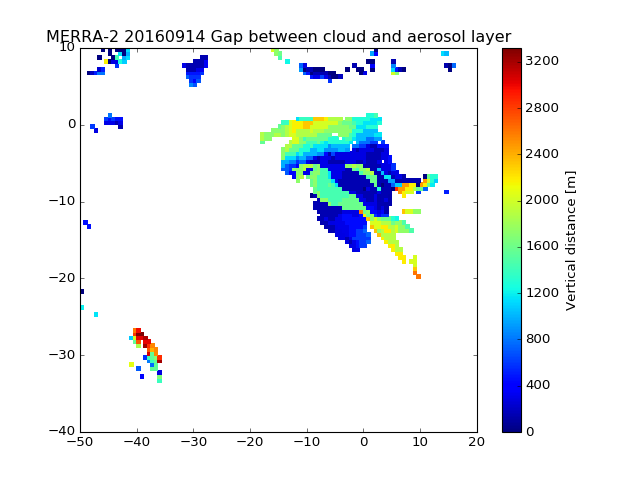

In [277]:
plt.figure()
plt.pcolor(maero['lon'],maero['lat'],za[1,:,:,0])
plt.colorbar(label='Vertical distance [m]')
plt.title('MERRA-2 {} Gap between cloud and aerosol layer'.format(day))

# Combine MERRA and 4STAR ORACLES gap

In [208]:
gap.keys()

[u'delta_alt',
 u'delta_lat',
 u'delta_lon2',
 u'delta_lon3',
 u'delta_lon1',
 u'delta_alt1',
 u'delta_alt2',
 u'ldelta_lat_days',
 u'delta_lat2',
 u'delta_lat3',
 u'delta_lat1',
 u'ldelta_alt',
 u'ldelta_lat',
 u'delta_lon',
 u'delta_alt3',
 u'ldelta_lon_days',
 u'ldelta_lon']

In [278]:
float(day)

20160914.0

In [280]:
iday = np.array(gap['days']) == float(day)

<IPython.core.display.Javascript object>


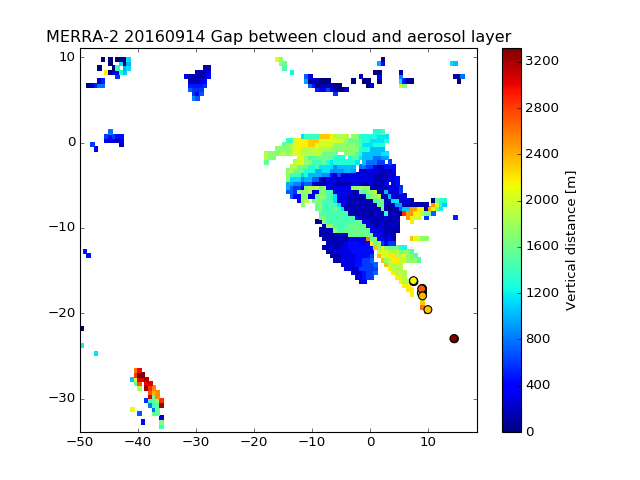

In [286]:
plt.figure()
plt.pcolor(maero['lon'],maero['lat'],za[1,:,:,0])
plt.colorbar(label='Vertical distance [m]')
plt.title('MERRA-2 {} Gap between cloud and aerosol layer'.format(day))

plt.scatter(gap['ldelta_lon'][iday],gap['ldelta_lat'][iday],50,c=gap['ldelta_alt'][iday],
            marker='o')

# Combine to make an average for all days

In [363]:
za_avg = np.zeros((len(maeroi['lat']),len(maeroi['lon'])))*np.nan
za_all = np.zeros((len(days),len(maeroi['lat']),len(maeroi['lon'])))*np.nan

In [367]:
for i,d in enumerate(days):
    za_all[i,:,:] = zab[i][4,:,:,0]

In [372]:
za_avg = np.nanmean(za_all,axis=0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [374]:
za_avg = np.ma.masked_array(za_avg,np.isnan(za_avg))

In [373]:
za_avg.shape

(101, 113)

In [417]:
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'

<IPython.core.display.Javascript object>


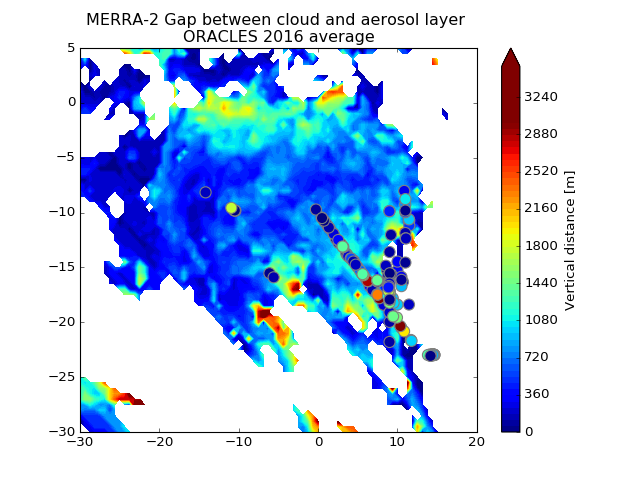

In [420]:
plt.figure()
plt.contourf(maeroi['lon'],maeroi['lat'],za_avg[:,:],60,vmin=0.0,vmax=3000.0,extend='max')
plt.colorbar(label='Vertical distance [m]')
plt.title('MERRA-2 Gap between cloud and aerosol layer \nORACLES 2016 average')
plt.scatter(gap['ldelta_lon'],gap['ldelta_lat'],100,c=gap['ldelta_alt'],marker='o',edgecolor='grey',vmin=0.0,vmax=3240.0,lw=1)
plt.xlim(-30,20)
plt.ylim(-30,5)
plt.savefig(fp+'MERRA2_ORACLES2016_gap_distance.png',transparent=True,dpi=600)

## Add a coastline

In [400]:
def mapfig(ax=plt.gca()):
    m = Basemap(projection='merc',llcrnrlat=-26,urcrnrlat=-8,llcrnrlon=-18,urcrnrlon=16,resolution='l',ax=ax)
    m.drawcoastlines()
    m.drawmeridians(np.linspace(-28,16,9),labels=[0,0,0,1],linewidth=0.1)
    m.drawparallels(np.linspace(-26,-8,10),labels=[1,0,0,0],linewidth=0.1)
    m.shadedrelief(alpha=0.4)
    return m

In [405]:
lon,lat = np.meshgrid(maeroi['lon'],maeroi['lat'])

In [416]:
fig,axa = plt.subplots(1,1)
m = mapfig(axa)
lon,lat = np.meshgrid(maeroi['lon'],maeroi['lat'])
mx,my = m(lon,lat)
axa.contourf(mx,my,za_avg[:,:],60,vmin=0.0,vmax=3000.0,extend='max',cmap='jet')
axa.set_title('MERRA-2 Gap between cloud and aerosol layer \nORACLES 2016 average')
plt.colorbar()
mxa,mya = m(gap['ldelta_lon'],gap['ldelta_lat'])
ax1.scatter(mxa,mya,100,c=gap['ldelta_alt'],marker='o',edgecolor='grey',vmin=0.0,vmax=3240.0,lw=1)


<IPython.core.display.Javascript object>

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).